# Project Part 2 Solutions

## (a)

In [1]:
import numpy as np

file=np.load("/Users/nickbachelder/Desktop/PSTAT 190DD/p2 proj/Fall-2020-DS-Project-Part-2/part2.npz")
beta_old=file['beta_old']
N=file['N']
Svc_0_PMF=file['Svc_0_PMF']
Lc=file['Lc']
Ic_0=file['Ic_0']
gamma=file['gamma']
L_observed=file['L_observed']
nb_nodes = Svc_0_PMF.shape[0]

In [2]:
def SIR(t, Z, N, betas, gamma):
    (S_vec, I_vec, R) = (Z[:16].reshape(4, 4), Z[16:20], Z[-1])
    I = I_vec.sum()
    dSdt = -betas*S_vec*I/N 
    dIdt = -dSdt.sum(axis=0)-gamma*I_vec
    dRdt = np.array([gamma*I])
    return np.concatenate((dSdt.flatten(), dIdt, dRdt))

In [3]:
from scipy.integrate import solve_ivp
from scipy.optimize import fmin
from sklearn.metrics import mean_squared_error

Svc_0_PMF /= Svc_0_PMF.sum(axis=(1, 2), keepdims=True)
Svc_0 = (N-Ic_0.sum(axis=1))[:, np.newaxis, np.newaxis]*Svc_0_PMF
Svc_0 = Svc_0.round().astype(int)
R0 = np.zeros((nb_nodes)).astype(int)

t = np.linspace(0, 199, 200)

S = np.zeros((nb_nodes, 4, 4, len(t)))
I = np.zeros((nb_nodes, 4, len(t)))
R = np.zeros((nb_nodes, len(t)))
L = np.zeros((nb_nodes, len(t)))

for N_node, node_index in zip(N, range(nb_nodes)):

    initial_conditions = np.concatenate(
        (Svc_0[node_index].flatten(), Ic_0[node_index], [R0[node_index]]))

    soln = solve_ivp(
        SIR, (t[0], t[9]), initial_conditions, args=(N_node, beta_old, gamma), t_eval=t[:10])

    S[node_index, :, :, :10] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, :10] = soln.y[16:20]
    R[node_index, :10] = soln.y[20]
    L[node_index, :10] = Lc@soln.y[16:20]

In [4]:
alpha_predicted = np.zeros((nb_nodes))


initial_conditions = [] ### Resetablish initial conditions for each node as 10th day values

for node_index in range(nb_nodes):
    initial_conditions.append(np.concatenate(
        (S[node_index, :, :, 9].flatten(), I[node_index, :, 9], [R[node_index, 9]])))

t = np.linspace(0, 199, 200)

def loss_func(alpha, t, init):
    soln = solve_ivp(
        SIR, (t[10], t[29]), initial_conditions[node_index], args=(N_node, (alpha*beta_old), gamma), t_eval=t[10:30])
    
    predicted = Lc@soln.y[16:20] ### Infected or dead people (N-S)
    observed = L_observed[node_index][10:30]
    mse = (1/(t[29]-t[10]))*np.square(observed - predicted).sum()
    return mse


for N_node, node_index in zip(N, range(nb_nodes)):
    alpha_predicted[node_index] = fmin(loss_func, 0.5, disp=False, args = (t, initial_conditions))
        
alpha_predicted

array([0.22669983, 0.39484253, 0.22185059, 0.73707123, 0.70143738,
       0.20029602, 0.35754395, 0.35007172, 0.3601532 , 0.16713867,
       0.27568665, 0.32045898, 0.31580811, 0.20931396, 0.12352142,
       0.22246094, 0.18051758, 0.56386108, 0.59924927, 0.14249268,
       0.26811523, 0.27178955, 0.49281006, 0.26390381, 0.33642883,
       0.15171814, 0.3757782 , 0.21018066, 0.44144897, 0.68422394,
       0.29797363, 0.3010498 , 0.39297028, 0.16387329, 0.61907349,
       0.66160202, 0.3225708 , 0.15137634, 0.28189697, 0.90992126,
       0.41170807, 0.43126221, 0.43154907, 0.17045288, 0.24889221,
       0.41756592, 0.71300049, 0.330896  , 0.23173828, 0.20965576,
       0.13822021, 0.20452881, 0.33418884, 0.26639404, 0.14807129,
       0.66747131, 0.17644043, 0.53582764, 0.27561264, 0.56835938,
       0.36387939, 0.27543945, 0.34067383, 0.42473755, 0.24645996,
       0.52313232, 0.20018311, 0.38779907, 0.46865234, 0.1552803 ,
       0.14443359, 0.33525391, 0.2932373 , 0.44838867, 0.41690

## (b)

In [5]:
### Resetablish initial conditions for each node as 30th day values by repeating simulation above and 
### recording SIR values


for N_node, node_index in zip(N, range(nb_nodes)):
    soln = solve_ivp(
        SIR, (t[10], t[29]), initial_conditions[node_index], args=(N_node, (alpha_predicted[node_index]*beta_old), gamma), t_eval=t[10:30])

    S[node_index, :, :, 10:30] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, 10:30] = soln.y[16:20]
    R[node_index, 10:30] = soln.y[20]
    L[node_index, 10:30] = Lc@soln.y[16:20]
    
initial_conditions = []
for node_index in range(nb_nodes):
    initial_conditions.append(np.concatenate(
        (S[node_index, :, :, 29].flatten(), I[node_index, :, 29], [R[node_index, 29]])))

In [6]:
def g(money):
    alpha = 1/np.log2(2*10**(-3)*money+2)
    return alpha

def g_inv(alpha):
    money = (2**(1/alpha)-2)/(2*10**(-3))
    return money
    import matplotlib.pyplot as plt 

def scatter_plot(alpha_afterNPI):
    plt.figure()
    colors=(beta_old[np.newaxis,:,:]*Svc_0_PMF).mean(axis=(1,2))
    plt.scatter(alpha_predicted, alpha_afterNPI, s=N/500, c=colors, cmap='jet', alpha=0.5)
    plt.xlabel(r"$\alpha_{own}$")
    plt.ylabel(r"$\alpha_{after\ NPI}$")

def total_recovered_difference(alpha_afterNPI):
    predict_beforeNPI = solve_ivp(
        SIR, (t[30], t[199]), initial_conditions[node_index], args=(N_node, alpha_predicted[node_index]*beta_old, gamma), t_eval=t[30:200])
    
    predict_afterNPI = solve_ivp(
        SIR, (t[30], t[199]), initial_conditions[node_index], args=(N_node, alpha_afterNPI[node_index]*beta_old, gamma), t_eval=t[30:200])
    
    total_d_i_day200_beforeNPI = N_node - predict_beforeNPI.y[:16].reshape(4, 4, -1).sum().sum() ### Total dead, recovered, and infected (N-S)
    total_d_i_day200_afterNPI = N_node - predict_afterNPI.y[:16].reshape(4, 4, -1).sum().sum()

    difference = total_d_i_day200_beforeNPI - total_d_i_day200_afterNPI 
    
    return np.array(difference)

### Policy #1

i.

In [7]:
### Spend the same on each node
spending_for_each_node = 1000000/nb_nodes

### Find post spending alpha values for each node

alpha_afterNPI = np.zeros((nb_nodes))

for node_index in range(nb_nodes):
    current_cost = g_inv(alpha_predicted[node_index])
    new_alpha = g(current_cost + spending_for_each_node)
    alpha_afterNPI[node_index] = new_alpha
    
alpha_afterNPI

array([0.18631644, 0.21328619, 0.18457962, 0.22243177, 0.22203708,
       0.17556498, 0.21043002, 0.20974009, 0.21066044, 0.15675392,
       0.19936105, 0.20649084, 0.20589211, 0.17960966, 0.12198757,
       0.18480365, 0.16513614, 0.2197998 , 0.22051829, 0.13840924,
       0.19778451, 0.19856595, 0.21787124, 0.19684887, 0.20835408,
       0.14570633, 0.21193712, 0.17997688, 0.21585681, 0.2218256 ,
       0.20332071, 0.20379807, 0.21316269, 0.15453822, 0.22086963,
       0.22152382, 0.20675386, 0.14544489, 0.2005605 , 0.22377786,
       0.21432112, 0.2153675 , 0.21538177, 0.15893429, 0.1931298 ,
       0.21465056, 0.22217119, 0.20774027, 0.18802031, 0.17975491,
       0.13486726, 0.17751522, 0.20810941, 0.1974074 , 0.14288097,
       0.2216049 , 0.1626993 , 0.21912921, 0.19934626, 0.21989843,
       0.21098056, 0.19931161, 0.20880402, 0.21503488, 0.19246525,
       0.21878993, 0.17551166, 0.21281184, 0.21700738, 0.14838893,
       0.13998515, 0.20822638, 0.20255539, 0.21617075, 0.21461

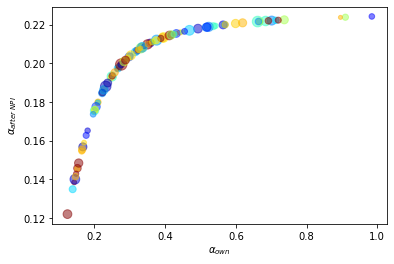

In [8]:
import matplotlib.pyplot as plt

scatter_plot(alpha_afterNPI)

In [9]:
#### Write comment on this method here!!!!!

ii.

In [10]:
### Find difference in total dead and infected people

infected_or_dead = []
for N_node, node_index in zip(N, range(nb_nodes)):
    infected_or_dead.append(total_recovered_difference(alpha_afterNPI))
    
totaldifference = np.array(infected_or_dead).sum().astype(int)

print('The NPI funding for policy 1 prevented {} people from becoming sick and/or dying.'.format(totaldifference))

The NPI funding for policy 1 prevented 45652464 people from becoming sick and/or dying.


### Policy #2

i. 

In [11]:
### Spend money proportional to population
spending_for_each_node = np.zeros((nb_nodes)) ## array of spending for each node (len = 100)

for N_node, node_index in zip(N, range(nb_nodes)):
    spending_for_each_node[node_index] = 1000000*(N_node/N.sum())

### Find post spending alpha values for each node

alpha_afterNPI_1 = np.zeros((nb_nodes))

for node_index in range(nb_nodes):
    current_cost = g_inv(alpha_predicted[node_index])
    new_alpha = g(current_cost + spending_for_each_node[node_index])
    alpha_afterNPI_1[node_index] = new_alpha
    
alpha_afterNPI_1

array([0.1876412 , 0.18658945, 0.18448618, 0.21104937, 0.19812434,
       0.18051695, 0.2025425 , 0.18815374, 0.22723512, 0.15496233,
       0.20519397, 0.20849776, 0.20131423, 0.18727112, 0.12138877,
       0.18918282, 0.17100541, 0.2103851 , 0.20599412, 0.14059695,
       0.20590467, 0.20917908, 0.19900549, 0.23126379, 0.20887315,
       0.14538564, 0.18291944, 0.18761193, 0.25857206, 0.19230632,
       0.19610401, 0.22183753, 0.20080195, 0.15728604, 0.20891606,
       0.18211517, 0.23343467, 0.14809433, 0.21105383, 0.24630211,
       0.19779822, 0.27155538, 0.20858147, 0.16483192, 0.17829431,
       0.2165835 , 0.23726224, 0.18501624, 0.16867959, 0.19323164,
       0.13515235, 0.17249228, 0.19065238, 0.19626268, 0.14517787,
       0.23621844, 0.16619592, 0.22455411, 0.16880456, 0.23439417,
       0.23331301, 0.20851994, 0.24447098, 0.23635373, 0.20622481,
       0.19469868, 0.17078897, 0.22920071, 0.18787737, 0.14676672,
       0.13720497, 0.18410828, 0.21413971, 0.28473294, 0.20306

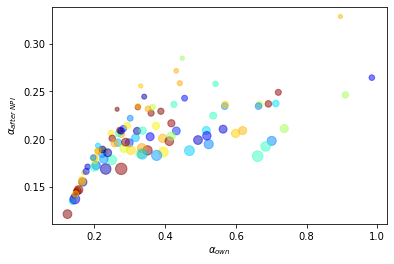

In [12]:
scatter_plot(alpha_afterNPI_1)

In [13]:
#### Write comment on this method here!!!!!

ii.

In [14]:
### Find difference in total dead and infected people

infected_or_dead = []
for N_node, node_index in zip(N, range(nb_nodes)):
    infected_or_dead.append(total_recovered_difference(alpha_afterNPI_1))
    
totaldifference = np.array(infected_or_dead).sum().astype(int)

print('The NPI funding for policy 2 prevented {} people from becoming sick and/or dying.'.format(totaldifference))

The NPI funding for policy 2 prevented 47811820 people from becoming sick and/or dying.


### Policy #3

i.

In [15]:
### Spend money for each node to make change in alpha equal for all nodes

spending_for_each_node = np.zeros((nb_nodes)) ## array of spending for each node (len = 100)

def budget(alpha_change):
    new_alphas = np.zeros((nb_nodes))
    current_costs = np.zeros((nb_nodes))
    new_alpha_total_cost = np.zeros((nb_nodes))
    moneyspent = np.zeros((nb_nodes))
    for node_index in range(nb_nodes):
        current_costs[node_index] = g_inv(alpha_predicted[node_index])
        new_alphas[node_index] = alpha_predicted[node_index] - alpha_change
        new_alpha_total_cost[node_index] = g_inv(new_alphas[node_index])
        moneyspent[node_index] = new_alpha_total_cost[node_index] - current_costs[node_index]
    moneyspent = np.array(moneyspent)
    return np.square(moneyspent.sum() - 1000000)
        

alpha_change = fmin(budget, 0, disp=False)

print('The alpha change that can be accomplished for all nodes within the budget is {}.'.format(alpha_change[0]))

The alpha change that can be accomplished for all nodes within the budget is 0.019732650756835942.


In [16]:
new_alphas = np.zeros((nb_nodes))
current_costs = np.zeros((nb_nodes))
new_alpha_total_cost = np.zeros((nb_nodes))
moneyspent = np.zeros((nb_nodes))
for node_index in range(nb_nodes):
        current_costs[node_index] = g_inv(alpha_predicted[node_index])
        new_alphas[node_index] = alpha_predicted[node_index] - 0.019732650756835942
        new_alpha_total_cost[node_index] = g_inv(new_alphas[node_index])
        moneyspent[node_index] = new_alpha_total_cost[node_index] - current_costs[node_index]
moneyspent

new_alphas

array([0.20696718, 0.37510988, 0.20211794, 0.71733858, 0.68170473,
       0.18056337, 0.33781129, 0.33033907, 0.34042055, 0.14740602,
       0.25595399, 0.30072633, 0.29607545, 0.18958131, 0.10378877,
       0.20272829, 0.16078493, 0.54412843, 0.57951662, 0.12276003,
       0.24838258, 0.2520569 , 0.47307741, 0.24417116, 0.31669618,
       0.13198549, 0.35604555, 0.19044801, 0.42171632, 0.66449129,
       0.27824098, 0.28131715, 0.37323763, 0.14414064, 0.59934084,
       0.64186937, 0.30283815, 0.13164369, 0.26216432, 0.89018861,
       0.39197542, 0.41152956, 0.41181642, 0.15072023, 0.22915956,
       0.39783327, 0.69326784, 0.31116335, 0.21200563, 0.18992311,
       0.11848756, 0.18479616, 0.31445619, 0.24666139, 0.12833864,
       0.64773866, 0.15670778, 0.51609499, 0.25587999, 0.54862672,
       0.34414674, 0.2557068 , 0.32094118, 0.4050049 , 0.22672731,
       0.50339967, 0.18045045, 0.36806642, 0.44891969, 0.13554765,
       0.12470094, 0.31552126, 0.27350465, 0.42865602, 0.39717

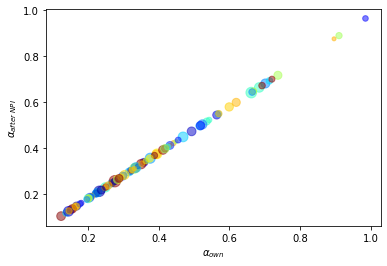

In [17]:
scatter_plot(new_alphas)

In [18]:
#### Write comment on this method here!!!!!

ii.

In [19]:
### Find difference in total dead and infected people

infected_or_dead = []
for N_node, node_index in zip(N, range(nb_nodes)):
    infected_or_dead.append(total_recovered_difference(new_alphas))
    
totaldifference = np.array(infected_or_dead).sum().astype(int)

print('The NPI funding for policy 3 prevented {} people from becoming sick and/or dying.'.format(totaldifference))

The NPI funding for policy 3 prevented 5839504 people from becoming sick and/or dying.


### Policy #4

i.

In [20]:
### Spend money for each node to make all alphas equal

spending_for_each_node = np.zeros((nb_nodes)) ## array of spending for each node (len = 100)

def alphasequal(alpha):
    spending_for_each_node = np.zeros((nb_nodes))
    current_costs = np.zeros((nb_nodes))
    totalmoney = g_inv(alpha)
    for node_index in range(nb_nodes):
        current_costs[node_index] = g_inv(alpha_predicted[node_index])
        spending_for_each_node[node_index] = totalmoney - current_costs[node_index]
    return np.square(spending_for_each_node.sum() - 1000000)
        
        
alpha_for_all = fmin(alphasequal, .15, disp=False)  
alpha_for_all[0]

print('The optimal alpha value to get all nodes to within the budget is {}.'.format(alpha_for_all[0]))

The optimal alpha value to get all nodes to within the budget is 0.18320688307285315.


In [21]:
### Find post spending alpha values for each node

alpha_afterNPI_4 = np.zeros((nb_nodes))

for node_index in range(nb_nodes):
    alpha_afterNPI_4[node_index] = 0.18320688307285315
    
alpha_afterNPI_4

array([0.18320688, 0.18320688, 0.18320688, 0.18320688, 0.18320688,
       0.18320688, 0.18320688, 0.18320688, 0.18320688, 0.18320688,
       0.18320688, 0.18320688, 0.18320688, 0.18320688, 0.18320688,
       0.18320688, 0.18320688, 0.18320688, 0.18320688, 0.18320688,
       0.18320688, 0.18320688, 0.18320688, 0.18320688, 0.18320688,
       0.18320688, 0.18320688, 0.18320688, 0.18320688, 0.18320688,
       0.18320688, 0.18320688, 0.18320688, 0.18320688, 0.18320688,
       0.18320688, 0.18320688, 0.18320688, 0.18320688, 0.18320688,
       0.18320688, 0.18320688, 0.18320688, 0.18320688, 0.18320688,
       0.18320688, 0.18320688, 0.18320688, 0.18320688, 0.18320688,
       0.18320688, 0.18320688, 0.18320688, 0.18320688, 0.18320688,
       0.18320688, 0.18320688, 0.18320688, 0.18320688, 0.18320688,
       0.18320688, 0.18320688, 0.18320688, 0.18320688, 0.18320688,
       0.18320688, 0.18320688, 0.18320688, 0.18320688, 0.18320688,
       0.18320688, 0.18320688, 0.18320688, 0.18320688, 0.18320

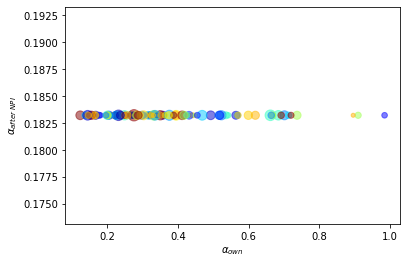

In [22]:
scatter_plot(alpha_afterNPI_4)

ii.

In [23]:
infected_or_dead = []
for N_node, node_index in zip(N, range(nb_nodes)):
    infected_or_dead.append(total_recovered_difference(alpha_afterNPI_4))
    
totaldifference = np.array(infected_or_dead).sum().astype(int)

print('The NPI funding for policy 3 prevented {} people from becoming sick and/or dying.'.format(totaldifference))

The NPI funding for policy 3 prevented 49540240 people from becoming sick and/or dying.


## (c)

### Policy 1

### Policy 2

### Policy 3

### Policy 4